In [9]:
import torch
import os
import sys
sys.path.append('/home/ebutz/ESL2024/code/utils' )
import optuna
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
import torch_geometric.transforms as T
import pickle
import os
import sys
import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from nxontology.imports import from_file
import wandb
from play_with_complex import *
from data_utils import *
from train_utils import *
from model_utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from torchmetrics.retrieval import RetrievalMRR, RetrievalHitRate
import play_with_complex as pwc
from work_in_graph import *
from usefull_little_functions import *
import numpy as np

from scipy.stats import ttest_ind
from scipy.stats import t

from nxontology import NXOntology

# Creating a little ontology (LO)
Creating ontology from adjacency tensors. The ontology is given under this form when one work with pyTorch.

/!\ CHECK THAT THE ONTOLOGY IN ORIENTED AS LO_EDGE_INDEX, that is to say that more specific nodes are children of less specific nodes. If not, swap the two parts of the ontology edge index (here thoses parts are commented Departure nodes and Arrival nodes)

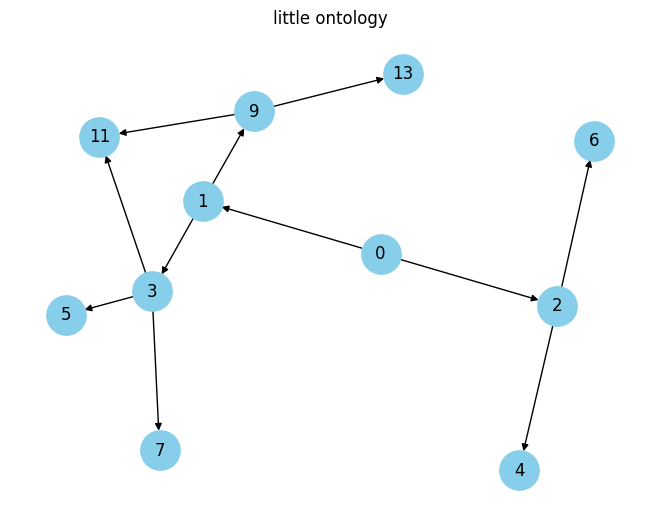

In [22]:
LO_edge_index = torch.tensor([[0,0,1,1,2,2,3,3,9, 9, 3],  # Departure nodes
                              [1,2,3,9,4,6,5,7,11,13, 11]], # Arrival nodes
                              dtype=torch.long)
LO_edges = LO_edge_index.t().tolist()

def plot_graph(graph, title="Graph"):
    """
    Plots the given graph using NetworkX.

    :param graph: A NetworkX graph object to be plotted.
    :param title: The title of the graph.
    """
    # Generate positions for the nodes in the graph
    pos = nx.spring_layout(graph, iterations=50, seed=4)
    
    # Draw the graph with node labels and arrows for directed edges
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=800, arrows=True)
    
    plt.title(title)
    plt.show()

def init_ontology(edges: list, display_output: bool = False, output_name = "ontology"):
    """
    Initializes an ontology using nxontology and adds edges to it.

    Args:
    edges: A list of edges to add to the ontology.
    display_output: If True, the graph is plotted.

    Returns:
    nxo: An NXOntology object with the specified edges.
    """
    # Create an NXOntology object
    nxo: NXOntology[str] = NXOntology()
    
    nxo.graph.graph["name"] = output_name
    
    # Set the graph attributes for node names
    nxo.set_graph_attributes(node_name_attribute="{node}")
    
    nxo.graph.add_edges_from(edges)

    if display_output:
        plot_graph(nxo.graph, title = output_name)

    return nxo

# Initialize the ontology with the specified edges and display the graph
LO = init_ontology(LO_edges, display_output=True, output_name = "little ontology")


In [27]:
list(LO.nodes)

[0, 1, 2, 3, 9, 4, 6, 5, 7, 11, 13]

# Rerieving leaves and their ancestors

In [31]:
def DFS(G, v, discovered):
    """
    Performs a Depth-First Search (DFS) on a directed graph.

    Args:
    G (nx.DiGraph): The directed graph in which to perform the DFS.
    v: The starting node for the DFS.
    discovered (set): A set to keep track of discovered nodes.

    Returns:
    set: A set of all nodes discovered during the DFS starting from node v.

    Source : https://en.wikipedia.org/wiki/Depth-first_search, july 10 2024.
    """
    discovered.add(v)  # Mark v as discovered

    for w in G.predecessors(v):    # Traverse all predecessors of v ;
        if w not in discovered:    # If the node w is not yet discovered ;
            DFS(G, w, discovered)  # Recursive DFS call on w ;

    return discovered


def get_leaves_and_ancestors(G):
    """
    Retrieves the leaves and their ancestors from an ontology graph.

    Args:
    edge_index (torch.Tensor): A tensor containing edge indices of the ontology graph.

    Returns:
    dict: A dictionary where each key is a leaf node and the value is a set of its ancestors.
    """
    # 1 - Listing nodes of the ontology:
    all_nodes: list = list(G.nodes) # List all elements of the edge_index

    # 3 - For each node, if the node has no children, add node to the list of leaves:
    leaves: list = []
    for node in tqdm(all_nodes, desc="Retrieving leaves from ontology"):
        if len(list(G.successors(node))) == 0:
            leaves.append(node)

    # 4 - Associate each leaf and its ancestors in a dict <leaf>: [ancestors]
    leaves_and_ancestors = dict()
    for leaf in tqdm(leaves, desc="Retrieving ancestors of each leaf"):
        discovered = set()
        leaves_and_ancestors[leaf] = DFS(G, leaf, discovered)

    return leaves_and_ancestors

leaves_ancestors = get_leaves_and_ancestors(LO)

Retrieving ancestors of each leaf: 100%|██████████| 6/6 [00:00<00:00, 46345.90it/s]

4 0 0.0
4 2 0.8607123478477108
4 4 1.0
6 0 0.0
6 2 0.8607123478477108
6 6 1.0
5 0 0.0
5 1 0.6593592294601535
5 3 0.8420437038909317
5 5 1.0
7 0 0.0
7 1 0.6593592294601535
7 3 0.8420437038909317
7 7 1.0
11 0 0.0
11 1 0.6490499497040011
11 3 0.8306478494045842
11 9 0.8972998943938413
11 11 1.0
13 0 0.0
13 9 0.9088994188631327
13 13 1.0
13 1 0.6593592294601535


# Retrieving leaf-ancestor similarity 

# Training models

In [37]:
def model_1(triplet):
    return 0
def model_2(triplet):
    return 1

# Comparing ontologies comprehension of the trained models

In [38]:


for leaf in leaves_ancestors.keys():
        for ancestor in leaves_ancestors[leaf]:
            print(leaf, ancestor, nxo.similarity(leaf, ancestor).lin, model_1((leaf, "is a", ancestor)), model_2((leaf, "is a", ancestor)))
            print()

4 0 0.0 0 1

4 2 0.8607123478477108 0 1

4 4 1.0 0 1

6 0 0.0 0 1

6 2 0.8607123478477108 0 1

6 6 1.0 0 1

5 0 0.0 0 1

5 1 0.6593592294601535 0 1

5 3 0.8420437038909317 0 1

5 5 1.0 0 1

7 0 0.0 0 1

7 1 0.6593592294601535 0 1

7 3 0.8420437038909317 0 1

7 7 1.0 0 1

11 0 0.0 0 1

11 1 0.6490499497040011 0 1

11 3 0.8306478494045842 0 1

11 9 0.8972998943938413 0 1

11 11 1.0 0 1

13 0 0.0 0 1

13 9 0.9088994188631327 0 1

13 13 1.0 0 1

13 1 0.6593592294601535 0 1



In [77]:

from scipy import stats



In [89]:
a = [0.5,10,100,140,147,200,400,600]
b = [0.5,10,100,140,156,198,500,700]


test = stats.pearsonr(a, b, alternative='two-sided')

print(test.pvalue, test.statistic)

6.961907969904491e-08 0.9969666284524281
